In [16]:
from subset_select_non_uniform_entropic_FISTA_git import subset_select_non_uniform_FISTA as ss
from subset_select_ipot_non_uniform_git import subset_select_ipot as ss_ipot
import shutil
import os
import open3d as o3d
import numpy as np
from matplotlib import pyplot as plt
import random
import torch


import utils

import numpy as np
from IPython.display import HTML, display, Markdown
import pandas as pd
import ot
import partial_gw as pgw
import matplotlib.pyplot as plt

from subset_select_ipot_non_uniform_git import subset_select_ipot as ss_ipot
from subset_select_non_uniform_entropic_FISTA_git import subset_select_non_uniform_FISTA as ss

:: Downsample with a voxel size 0.007.
:: Estimate normal with search radius 0.020.
:: Compute FPFH feature with search radius 0.050.


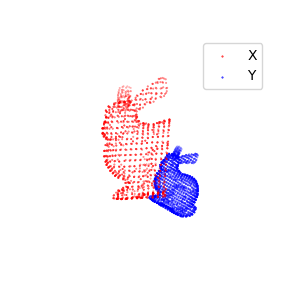

In [26]:
%matplotlib widget

voxel_size = 0.007

bunnymesh_Data = o3d.data.BunnyMesh()
bunny_mesh = o3d.io.read_triangle_mesh(bunnymesh_Data.path)
bunny_mesh.compute_vertex_normals()

pcd_mesh = o3d.io.read_point_cloud(bunnymesh_Data.path)
pcd = pcd_mesh.voxel_down_sample(voxel_size=voxel_size)

# o3d.visualization.draw_geometries([pcd])

# from open3d documentation


def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = 0.02
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = 0.05
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh


Y_pcd, Y_fpfh = preprocess_point_cloud(pcd, voxel_size=voxel_size)

Y_pc = np.asarray(Y_pcd.points)

# alph = (np.pi/12)
# Q = np.array([[np.cos(alph), -np.sin(alph), 0], [np.sin(alph),  np.cos(alph), 0], [0, 0, 1]])
# X_pc0 = Y_pc

X_pc0 = Y_pc[Y_pc[:, 0] < 0]
alph = (np.pi/6)
Q = np.array([[np.cos(alph), -np.sin(alph), 0],
             [np.sin(alph),  np.cos(alph), 0], [0, 0, 1]])
X_pc = 2*(X_pc0)@Q.T 


fig = plt.figure(1, figsize=(3,3))
ax1 = fig.add_subplot(1,1, 1, projection='3d')
ax1.scatter(X_pc[:, 0], X_pc[:, 1], X_pc[:, 2], facecolor="r", label="X", s=0.2)
ax1.scatter(Y_pc[:, 0], Y_pc[:, 1], Y_pc[:, 2], facecolor="b",  label="Y", s=0.2)
ax1.set_aspect("auto")
# ax1.set_xlabel("x")
# ax1.set_ylabel("y")
# ax1.set_zlabel("z")
# ax1.set_title("X")
ax1.axis("off")
ax1.view_init(90, -60)
ax1.grid(visible=0)
ax1.legend()
# fig.savefig("bunny.pdf", dpi=500, pad_inches = 0, bbox_inches=0, format='pdf')
# fig.savefig("bunny.png", dpi=500, pad_inches = 0, bbox_inches=0, format='png')
# fig.savefig("bunny.svg", dpi=500, pad_inches = 0, bbox_inches=0, format='svg')

In [27]:
Cx = np.linalg.norm(X_pc - X_pc[:, None, :], axis=2)
Cy = np.linalg.norm(Y_pc - Y_pc[:, None, :], axis=2)

In [28]:
p = np.ones(len(X_pc))/len(X_pc)
q = np.ones(len(Y_pc))/len(Y_pc)

In [29]:
T, loss = pgw.pu_gw_emd(Cx, Cy, p, q, nb_dummies=1, group_constraints=False, G0=None, log=True, max_iter=2000)


In [33]:
# perfs_ds_pgw, perfs_list_pgw, yu_list_pGW, yhat_list_pGW, nu_star_list_pGW = pgw.compute_perf_pgw('decaf_caltech', ds_ul, n_pos, n_unl, prior, nb_reps, nb_dummies)
T

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
# x = np.linspace(0,10, 100)
# np.random.shuffle(x)
# y = 2*x
# X = np.concatenate((x[:,None],y[:, None]), axis=1)
# A = np.linalg.norm(X - X[:,None,:], axis=-1)

In [28]:
# def ipot(X, Y, mu, nu, gamma, max_outer_iter, max_inner_iter, disp_iter=False, return_map=False):
#     M = np.linalg.norm(X[:, np.newaxis, :] - Y, axis=2)**2
#     K = np.exp(- M / gamma)
#     m, n = K.shape
#     mu = mu.reshape([m, 1])
#     nu = nu.reshape([n, 1])

#     P = np.ones_like(K)/(m*n)
#     alpha = np.zeros([m, 1])
#     beta = np.zeros([n, 1])
#     costs = []

#     for outer_iter in range(0, max_outer_iter):
#         Q = K*P
#         for inner_iter in range(0, max_inner_iter):
#             alpha = gamma*(np.log(Q@np.exp(-beta/gamma)) - np.log(mu))
#             beta = gamma*(np.log(Q.T@np.exp(-alpha/gamma)) - np.log(nu))

#         P = np.diag(np.exp(-alpha.squeeze()/gamma)) @ (Q @ np.diag(np.exp(-beta.squeeze()/gamma)))
#         costs.append(np.sum(P*M))

#         if disp_iter == True:
#             print("iter = ", outer_iter)
#             print("cost = ", costs[-1])

#     if return_map == True:
#         return costs, P
#     else:
#         return costs


In [11]:
from subset_select_non_uniform_entropic_FISTA_git import subset_select_non_uniform_FISTA as ss
from subset_select_ipot_non_uniform_git import subset_select_ipot as ss_ipot
import shutil
import os
import open3d as o3d
import numpy as np
from matplotlib import pyplot as plt
import random
import torch 

(10, 2)